<a href="https://colab.research.google.com/github/ggrindstaff/Connectivity/blob/Automated-Earthwork-Detection/Colab_notebooks/Copy_of_BERM_PlottingCycles1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies and import data

Install custom ripser package, cython dependency already available

In [1]:
#!pip install ripser
!git clone https://github.com/ggrindstaff/ripser.py
%cd ripser.py
!pip install -e .

Cloning into 'ripser.py'...
remote: Enumerating objects: 3424, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 3424 (delta 192), reused 337 (delta 166), pack-reused 3021
Receiving objects: 100% (3424/3424), 20.33 MiB | 20.00 MiB/s, done.
Resolving deltas: 100% (1993/1993), done.
/content/ripser.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ripser.py
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 519 kB/s 
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18120 sha256=562428267b27f2284293f95c678b825d98dd553dfb89bc8201de316f459a1931
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built hopcroftkarp
  Runnin

Code based on 
https://ripser.scikit-tda.org/en/latest/notebooks/Lower%20Star%20Image%20Filtrations.html

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib.transforms import Affine2D
import scipy
from scipy import ndimage
import PIL
import random
!pip install geopandas
import geopandas as gpd
import pandas as pd


from persim import plot_diagrams, bottleneck, sliced_wasserstein, wasserstein, bottleneck_matching, PersImage,PersistenceImager, landscapes
from ripser import ripser, lower_star_img, Rips
from persim.persistent_entropy import *
from scipy import stats
from scipy import sparse


plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 2.1 MB/s 
     |████████████████████████████████| 16.7 MB 28.4 MB/s 
     |████████████████████████████████| 6.3 MB 23.1 MB/s 


In [3]:
def img_to_sparse(img):
  # Modified from source code
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))

    return sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))


def cocycles_to_plot(cocycles,d,rotate=False):
  m,n = d.shape
  birthloc = [cocycles[0][i][0][0] for i in range(len(cocycles[0]))]
  # persistence = [cocycles[0][i][0][1]-cocycles[0][i][0][0] for i in range(len(cocycles[0]))]
  xloc = []
  yloc = []
  for ind in birthloc:
    if rotate==False:
      yi = int(ind/n)
      xi = ind%n
    if rotate==True:
      yi = m-int(ind/n)-1
      xi = ind%n  
    xloc.append(xi)
    yloc.append(yi)
  return xloc,yloc


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
bigAOI = np.loadtxt('/content/gdrive/MyDrive/DEM_simplesite.csv',delimiter=',')

Mounted at /content/gdrive


# Load data and compute persistence diagrams

In [5]:
directory = 'https://raw.githubusercontent.com/ggrindstaff/Connectivity/master/'#/content/Connectivity/Berms/'
name = 'berms'
files = [
         bigAOI,
        #  bigAOI1 ,
        #  bigAOI2  
         ]

N=len(files)

import scipy.ndimage

dgm0 = {i:[] for i in range(N)} # output 0th homology data
dgm0_adj= {i:[] for i in range(N)} # output 0th homology data
dgm1 = {i:[] for i in range(N)} # output 1th homology data
data = {i:[] for i in range(N)} # DEM data for examples
data2 = {i:[] for i in range(N)} # DEM data with noise for examples
cocycles = {i:[] for i in range(N)}

for i in range(len(files)):
  data[i] = files[i]
  if i>3:
    d = ndimage.interpolation.zoom(data[i],.5) #decimate resolution
  else:
    d = data[i]
  data2[i] = d + 0.00001*np.random.rand(d.shape[0],d.shape[1])
  if 'stockpond' in files[i]:
    sparseDM = img_to_sparse(data2[i])
    rip = ripser(sparseDM, distance_matrix=True, maxdim=0, do_cocycles=True)
    dgm0[i] = rip["dgms"][0]
    cocycles[i] = rip["cocycles"]
  else:
    sparseDM = img_to_sparse(data2[i])
    rip = ripser(-sparseDM, distance_matrix=True, maxdim=0, do_cocycles=True)
    dgm0[i] = rip["dgms"][0]
    cocycles[i] = rip["cocycles"]
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


#Plot cycle locations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


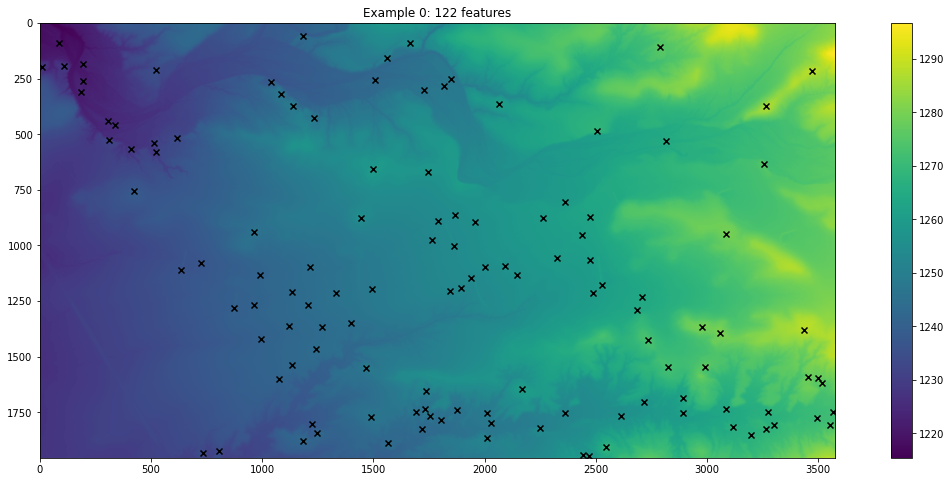

In [6]:
# plot cycle locations on DEM data

thresh = 0.6 #these should be the min and max height that a berm would be relative to its surroundings
thresh1 = thresh
max_thresh = 3
noisethresh = 7
xvals_all = []
yvals_all = []

for i in range(1):#range(len(data2)):
  
  if 'stockpond' in files[i]:
    dgm = dgm0[i]
    idxs = np.arange(dgm.shape[0])
    idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh1]
  else:
    idxs = np.arange(dgm0[i].shape[0])
    idxs = idxs[(np.abs(dgm0[i][:, 1] - dgm0[i][:, 0]) > thresh) &
                (np.abs(dgm0[i][:, 1] - dgm0[i][:, 0]) < max_thresh)]


  xvals, yvals = cocycles_to_plot(cocycles[i],data2[i],rotate=False)
  xcycle = np.array(xvals)[idxs]
  ycycle = np.array(yvals)[idxs]
  mask = (xcycle>noisethresh)&(xcycle<len(data2[i][0])-noisethresh)&(ycycle>noisethresh)&(ycycle<len(data2[i])-noisethresh)
  xcycle = xcycle[mask]
  ycycle = ycycle[mask]
  xvals_all.append(xcycle)
  yvals_all.append(ycycle)

  features = dgm0[0][idxs][mask]

  plt.figure(figsize = (20,8))
  shw = plt.imshow(data2[i], cmap = 'viridis')
  if i==6:
    shw = plt.imshow(data2[i],cmap='viridis',vmin=1000)
  plt.scatter(xcycle,ycycle,c='k', marker='x')
  plt.title('Example ' + str(i) +': '+str(len(xcycle))+' features')
  # plt.axis('off')
  plt.colorbar(shw)
  plt.show()

In [7]:
len(features)

122

In [8]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

dist = 10

sizes = []
vols = []

for i in range(len(features)):
  f = features[i]
  print(i,'of',len(features))
  # plt.figure(figsize = (15,8))
  hwidth = 0#abs(f[1]-f[0])/2
  im = np.where((data2[0]>=-f[1]) & (data2[0]<=-f[0]-hwidth),1,0)
  # plt.scatter(xcycle[i],ycycle[i])
  # plt.imshow(im)

  blobs = im
  all_labels = measure.label(blobs)
  blobs_labels = measure.label(blobs, background=0)

  poss_comps = list(dict.fromkeys(blobs_labels[ycycle[i]-dist:ycycle[i]+dist,xcycle[i]-dist:xcycle[i]+dist].flatten()))
  poss_comps = [p for p in poss_comps if p>0]
  if len(poss_comps)==0:
    dist1 = dist*2
    poss_comps = list(dict.fromkeys(blobs_labels[ycycle[i]-dist1:ycycle[i]+dist1,xcycle[i]-dist1:xcycle[i]+dist1].flatten()))
    poss_comps = [p for p in poss_comps if p>0]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(dict.fromkeys(blobs_labels[ycycle[i]-dist1:ycycle[i]+dist1,xcycle[i]-dist1:xcycle[i]+dist1].flatten()))
    poss_comps = [p for p in poss_comps if p>0]
    if len(poss_comps)>1:
      dist1 = int(dist/4)
      poss_comps = list(dict.fromkeys(blobs_labels[ycycle[i]-dist1:ycycle[i]+dist1,xcycle[i]-dist1:xcycle[i]+dist1].flatten()))
      poss_comps = [p for p in poss_comps if p>0]
    if len(poss_comps)==0:
      dist1 = int(dist)
      poss_comps = list(dict.fromkeys(blobs_labels[ycycle[i]-dist1:ycycle[i]+dist1,xcycle[i]-dist1:xcycle[i]+dist1].flatten()))
      poss_comps = [p for p in poss_comps if p>0]

  if len(poss_comps)>2:
    print(i,'rats')

  blob_thisonly = np.where(blobs_labels==poss_comps[0],1,0)
  # plt.imshow(blob_thisonly)
  # plt.imshow(blobs_labels)
  size = sum(blob_thisonly.flatten())
  dat1 = data2[0]*blob_thisonly
  mindat = np.nanmin([d for d in dat1.flatten() if d>0])
  dat1 = np.where(dat1==0,np.nan,dat1)
  dat1 = dat1-mindat
  vol = np.nansum(dat1.flatten())
  vols.append(vol)
  sizes.append(size)


0 of 122
1 of 122
2 of 122
3 of 122
4 of 122
5 of 122
6 of 122
7 of 122
8 of 122
9 of 122
10 of 122
11 of 122
12 of 122
13 of 122
14 of 122
15 of 122
16 of 122
17 of 122
18 of 122
19 of 122
20 of 122
21 of 122
22 of 122
23 of 122
24 of 122
25 of 122
26 of 122
27 of 122
28 of 122
29 of 122
30 of 122
31 of 122
32 of 122
33 of 122
34 of 122
35 of 122
36 of 122
37 of 122
38 of 122
39 of 122
40 of 122
41 of 122
42 of 122
43 of 122
44 of 122
45 of 122
46 of 122
47 of 122
48 of 122
49 of 122
50 of 122
51 of 122
52 of 122
53 of 122
54 of 122
55 of 122
56 of 122
57 of 122
58 of 122
59 of 122
60 of 122
61 of 122
62 of 122
63 of 122
64 of 122
65 of 122
66 of 122
67 of 122
68 of 122
69 of 122
70 of 122
71 of 122
72 of 122
73 of 122
74 of 122
75 of 122
76 of 122
77 of 122
78 of 122
79 of 122
80 of 122
81 of 122
82 of 122
83 of 122
84 of 122
85 of 122
86 of 122
87 of 122
88 of 122
89 of 122
90 of 122
91 of 122
92 of 122
93 of 122
94 of 122
95 of 122
96 of 122
97 of 122
98 of 122
99 of 122
100 of 122

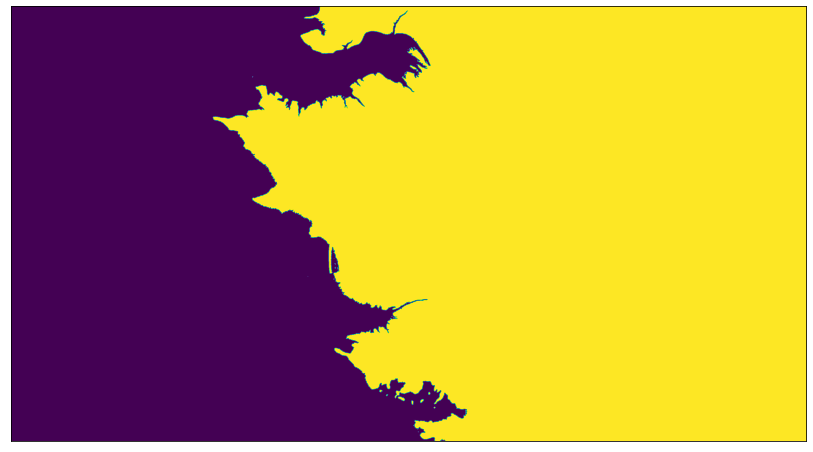

In [9]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (15,8))
im = np.where(bigAOI>1248,1,0)
plt.xticks([])
plt.yticks([])
plt.imshow(im)

In [10]:
top_left = {'AOI1':[459608.277,3539624.483],#459605, 3539900],
            'AOI2':[449950, 3530350],
            'newAOI':[579609.5093000503, 3519853.59535345]} #[459605,3539650]
aoi = 'newAOI'

In [11]:
df1= pd.DataFrame.from_dict({'Lat':yvals_all[0],
                             'Lon':xvals_all[0]})
df1['Lat'] = -df1.Lat+top_left[aoi][1]#-len(data2[0])
df1['Lon'] = df1.Lon+top_left[aoi][0]
df1['s'] = sizes
df1['vol'] = vols
df1['ratio'] = df1.vol/df1.s
df1['birth'] = [f[0] for f in features]
df1['death'] = [f[1] for f in features]
# df = df[(df.s>500) & (df.s<725)]
# (df1.s>500) & (df1.s<2000) & (df1.ratio>0.5) & (df1.ratio<0.9)]
df = df1[(df1.s>500) & (df1.s<2000) 
         & (df1.ratio>0.5) & (df1.ratio<1.0)]
key = 0
# births = np.array([p[0] for p in dgm0[key]])[mask_all]
# deaths = np.array([p[1] for p in dgm0[key]])[mask_all]
# df['height'] = deaths-births
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Lon, 
                                    df.Lat,crs='EPSG:32612'))
gdf.to_file('features_simplesite.shp')

In [12]:
!pip install rasterio
import rasterio
from rasterio.plot import show
r = rasterio.open('/content/gdrive/MyDrive/DEM_simplesite.tif')
!pip install matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 307 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


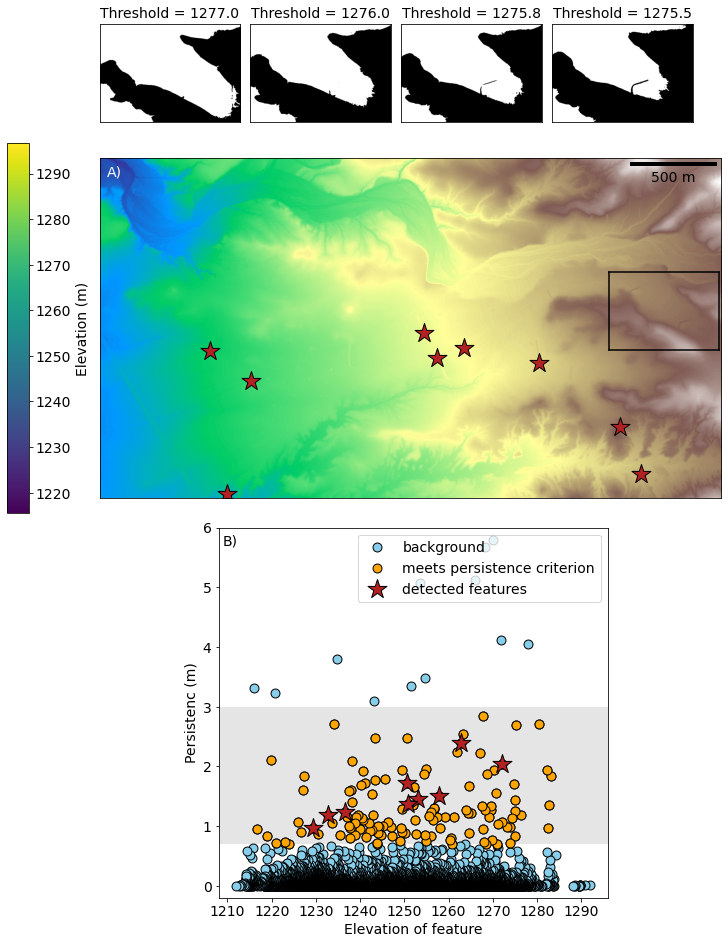

In [13]:
# plot cycle locations on DEM data
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch

thresh = 0.6 #these should be the min and max height that a berm would be relative to its surroundings
thresh1 = thresh
max_thresh = 3
noisethresh = 7

plt.rcParams.update({'font.size': 14})

fig = plt.figure(constrained_layout=True, figsize = (10,13))
spec = gridspec.GridSpec(ncols=18, nrows=7, figure=fig)
axt0 = fig.add_subplot(spec[0, 1:5])
axt1 = fig.add_subplot(spec[0, 5:9])
axt2 = fig.add_subplot(spec[0, 9:13])
axt3 = fig.add_subplot(spec[0, 13:17])
cax = fig.add_subplot(spec[1:4, 0]) # this is the colorbar
ax0 = fig.add_subplot(spec[1:4, 1:]) # this is the colorbar
ax1 = fig.add_subplot(spec[4:, 4:14]) # this is the colorbar

rvals = r.read(1)[700:1100,3000:]
thresholds = [1277,1276,1275.85,1275.5,]
axs = [axt0,axt1,axt2,axt3]

for i in range(len(axs)):
  ax = axs[i]
  t = thresholds[i]
  rv = np.where(rvals>=t,1,0)
  ax.imshow(rv, cmap='binary')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title('Threshold = %4.1f' %(t),
               fontsize = 14)# )

ax = ax0
show(r,ax=ax,cmap='terrain')
ax.plot([582540,583170],[3.51875e6]*2,c='k')
ax.plot([582540,583170],[3.5192e6]*2,c='k')
ax.plot([582540,582540],[3.51875e6,3.5192e6],c='k')
ax.plot([583170]*2,[3.51875e6,3.5192e6],c='k')
gdf.to_crs('EPSG:26912').plot(ax=ax,c='firebrick',
                              edgecolor= 'k',
                              marker = '*',
                              markersize = 400)
ax.set_xticks([])
ax.set_yticks([])



cbar = plt.colorbar(shw,cax = cax)
cbar.set_label('Elevation (m)')

ax = ax1
births = np.array([p[0] for p in dgm0[key]])#[mask_all]
deaths = np.array([p[1] for p in dgm0[key]])#[mask_all]
locs = (births+deaths)/2+4.5
persistence = deaths-births
berms_pers = persistence[(persistence>0.7) &
                       (persistence<3)]
berms_loc = locs[(persistence>0.7) &
                       (persistence<3)]

ax.scatter(-locs,
          persistence,
          label='background',c='skyblue',edgecolor = 'k',s=80, )

ax.scatter(-berms_loc,
          berms_pers,
          c='orange',
           edgecolor = 'k',s=80, 
           label='meets persistence criterion')

# xv, yv = cocycles_to_plot(cocycles[0],data2[0],rotate=False)
births_berm = gdf.birth
deaths_berm = gdf.death
locs_berm = (births_berm+deaths_berm)/2+4.5
pers_berms = deaths_berm-births_berm



ax.scatter(-locs_berm, pers_berms,
           label='detected features',
           c='firebrick',
           edgecolor = 'k',
           s=400,
           marker = '*')

ax.legend(loc='upper right')
ax.axhspan(0.7,3,facecolor = 'k',alpha=0.1,zorder = -10)
ax.set_ylim(-0.2,6)
ax.set_xlabel('Elevation of feature')
ax.set_ylabel('Persistenc (m)')

ax0.text(579650,3.51975e6,'A)',c='white')
ax1.text(1209,5.7,'B)')

# add scale bar and north arrow

ax0.add_artist(ScaleBar(1,box_alpha=0))


plt.savefig('bigtest_results.png',format='png',dpi=300,bbox_inches='tight')